# DL Language Model



1.1 Load Raw Text Corpus  
1.2 Clean Text and Create Text Tokens  
1.3 Numericalized Tokens  
1.4 Pre-trained LM weights  
1.5 Language Model and Concatenate all documents  
1.6 Fit Language Model  
1.7 Measuring LM performance  
 

# Preliminaries

In [1]:
from fastai.text import *
import html
print(torch.__version__)
print(np.__version__)
# torch version should be pre 1.0 for compatibility with Fastai 0.7
# np version should be 1.15 for compatibility with Fastai 0.7

%run -i ./code/sentiment_imdb_helpers.py

PATH=Path('data/aclImdb/')

# in NLP you will see LM (Language Model) path by convention
LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

# Clas Path and Col Names
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

chunksize=24000
col_names = ['labels','text']

0.3.1.post2
1.15.1


## 1.1 Load Data

In [2]:
# find it much easier to process text within Python, rather than helper functions
#   processing text with Python is straight forward, not that hard
# load, shuffle, create df, save 

#uncomment the nextlines only the first time to load imdb data and create dataframes
%run -i ./code/sentiment_imdb_load_createdf.py
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

data/aclImdb/train/neg
data/aclImdb/train/pos
data/aclImdb/train/unsup
data/aclImdb/test/neg
data/aclImdb/test/pos
data/aclImdb/test/unsup


array([0, 0, 0, ..., 2, 2, 2])

75000 75000


,labels,text
0,2,Awesome blend of love and suspense. A top clas...
1,0,"Look, I loved the PROPER Anchorman film, but t..."
2,1,"Set in World Depression Era Prague, this is th..."
3,2,<br /><br /> Praise is the only thing I can gi...
4,2,There's a general rule to follow about Bogart ...


['neg\n', 'pos\n', 'unsup\n']


#### Classifier Data

In [3]:
# CLASSIFIER PATH
#
# Create Data Frames ... DONT RUN THIS UNLESS NEED TO RECREATE DataFrames and SAVE
# create dataframes and save to file
# Standardized format for NLP
# datarames used later

df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

display(df_trn.head())

# save data frame
# Classifier data ... no header by default
# after removing unsupervised (unlabeled classes = 2) there will be 25 K positive and 25 K negative
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)
print((CLAS_PATH/'classes.txt').open().readlines())

,labels,text
0,2,Awesome blend of love and suspense. A top clas...
1,0,"Look, I loved the PROPER Anchorman film, but t..."
2,1,"Set in World Depression Era Prague, this is th..."
3,2,<br /><br /> Praise is the only thing I can gi...
4,2,There's a general rule to follow about Bogart ...


['neg\n', 'pos\n', 'unsup\n']


####  Language Model Data ...  train test split 

In [4]:
# LANGUAGE MODEL

# convenient function for splitting training and test data set, 10% for test 
#  LM we create our own validation set ... use sklearn train_test_split ... we specify the proportion
#  random split into train and validation
#  concatenate classification and training together 100K all together ... split into 10% test, 90% training
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

print(len(trn_texts), len(val_texts))

# for the language model there are no labels, so we use zeros
# using these standard formats just makes things easier for repeating consistent dataframe and csv 
# this for other data sets
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

# 
df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

90000 10000


##### To save time, Skip these next few cells and go to "np.load()" 

# 1.2 Tokenize (text tokens)

#### Read in the data frame again (... we could start from here in the future, after preliminaries)

In [5]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [6]:
# https://forums.fast.ai/t/lesson-4-oserror-cant-find-model-en/11252/4
# pip install SpaCy
# python -m spacy download en
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


Here is the result at the end [35:42]. Beginning of the stream token (xbos), beginning of field number 1 token (xfld 1), and tokenized text. You’ll see that the punctuation is on whole now a separate token.

t_up: t_up mgm — MGM was originally capitalized. But the interesting thing is that normally people either lowercase everything or they leave the case as is. Now if you leave the case as is, then “SCREW YOU” and “screw you” are two totally different sets of tokens that have to be learnt from scratch. Or if you lowercase them all, then there is no difference at all. So how do you fix this so that you both get a semantic impact of “I’M SHOUTING NOW” but not have to learn the shouted version vs. the normal version. So the idea is to come up with a unique token to mean the next thing is all uppercase. Then we lowercase it, so now whatever used to be uppercase is lowercased, and then we can learn the semantic meaning of all uppercase.

tk_rep: Similarly, if you have 29 ! in a row, we don’t learn a separate token for 29 exclamation marks — instead we put in a special token for “the next thing repeats lots of times” and then put the number 29 and an exclamation mark (i.e. tk_rep 29 !). So there are a few tricks like that. If you are interested in NLP, have a look at the tokenizer code for these little tricks that Jeremy added in because some of them are kind of fun.

  ' '.join(tok_trn[0])

In [7]:
' '.join(tok_trn[0])

'\n xbos xfld 1 i saw this movie at the dragon*con 2006 independent film festival . it was awarded 2 awards at that festival and rightfully so . this is probably the best short horror film i \'ve ever seen . the simplicity of camera usage really works.the main character is brilliant . his acting is quite good and is believable . the 3 cameras in the room with tim russel make his insanity that much more believable . i love it . i have talked with mike and he says that they are in the process of making a feature film compassing the first three chapters together . i ca n\'t wait . i will be first in line for that film . the effects of the " mirror " creatures are used so well . you do n\'t see them for very long so it scares the pants off of you when you do . i recommend this film to anyone who wants to watch a good horror movie for once . best 32 minutes of spine tingling horror i \'ve ever seen . thanks mike .'

In [8]:
# save this and load back up later ... 
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val )

The nice thing with doing things this way is we can now just np.save that and load it back up later [37:44]. We don’t have to recalculate all this stuff each time like we tend to have to do with torchtext or a lot of other libraries. Now that we got it tokenized, the next thing we need to do is to turn it into numbers which we call numericalizing it. The way we numericalize it is very simple.

* We make a list list of all the words that appear in some order
* Then we replace every word with its index into that list
* The list of all the tokens, we call that the vocabulary.

## 1.3 Numericalized Tokens

In [9]:
# np.load
# tokenize -> numericalize it ... all the tokens we call the vocabularty
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

The Counter class in Python is very handy for this. It basically gives us a list of unique items and their counts. Here are the 25 most common things in the vocabulary. Generally speaking, we don’t want every unique token in our vocabulary. If it doesn’t appear at least twice then might just be a spelling mistake or a word we can’t learn anything about it if it doesn’t appear that often. Also the stuff we are going to be learning about so far in this part gets a bit clunky once you’ve got a vocabulary bigger than 60,000. Time permitting, we may look at some work Jeremy has been doing recently on handling larger vocabularies, otherwise that might have to come in a future course. But actually for classification, doing more than about 60,000 words doesn’t seem to help anyway.

In [10]:
#  this is sorted by frequency
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1208449),
 ('.', 992545),
 (',', 986614),
 ('and', 587567),
 ('a', 583520),
 ('of', 525412),
 ('to', 484871),
 ('is', 393923),
 ('it', 341485),
 ('in', 337351),
 ('i', 307751),
 ('this', 270410),
 ('that', 261107),
 ('"', 237920),
 ("'s", 222037),
 ('-', 188209),
 ('was', 180235),
 ('\n\n', 179009),
 ('as', 166145),
 ('with', 159253),
 ('for', 158601),
 ('movie', 157735),
 ('but', 150659),
 ('film', 144618),
 ('you', 123979)]

The vocab is the unique set of all tokens in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index. In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set max_vocab to 60000.

Note, time permitting we will discuss larger vocab sizes, but may not have time in this course. So we are going to limit our vocabulary to 60,000 words, things that appear at least twice [39:33]. Here is a simple way to do that. Use .most_common (Counter), pass in the max vocab size. That’ll sort it by the frequency and if it appears less often than a minimum frequency, then don’t bother with it at all.

That gives us itos — that’s the same name that torchtext used and it means integer-to-string. This is just the list of unique tokens in the vocab. We’ll insert two more tokens — a vocab item for unknown (unk) and a vocab item for padding (pad).

In [11]:
max_vocab = 60000
min_freq = 2

In [12]:
# must appear greater than min_freq ... words must appear at least 2x or don't bother
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
# insert two more tokens ... padding and uknown
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')
print(itos[0:5])
# the index is the id ... of the word itos[id] = some word

['_unk_', '_pad_', 'the', '.', ',']


We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

We can then create the dictionary which goes in the opposite direction (string to integer)[40:19]. That won’t cover everything because we intentionally truncated it down to 60,000 words. If we come across something that is not in the dictionary, we want to replace it with zero for unknown so we can use defaultdict with a lambda function that always returns zero.

In [13]:
# some items will not be in the dictonary (e.g., did not appar twice in the text) 
#  so use default dict and fill with 0 for such cases
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
print(stoi['_unk_'])
len(itos)

0


60002

#### Numericalized Corpus

In [14]:
# NUMERICALIZED CORPUS
# this is where the default dictionary comes in 
#  when trying to access stoi[i] there is a chance that o is not in the dictionary
#  in that case the default dict will employ it's default factory, which in this case generates a 0
# for every reveiw use stoi to replace string token with an integer token 
# this is the "numericalized" corpus
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

print(type(trn_lm))
trn_lm.shape

<class 'numpy.ndarray'>


(90000,)

Here is our numericalized corpus

In [15]:
' '.join(str(o) for o in trn_lm[0])

'40 41 42 39 12 235 13 23 44 2 0 3368 1662 25 1331 3 10 18 8833 261 2474 44 14 1331 5 9383 51 3 13 9 263 2 138 364 200 25 12 159 143 129 3 2 5416 7 371 9080 83 58696 305 122 9 556 3 35 136 9 204 66 5 9 842 3 2 379 3992 11 2 655 21 1895 13095 113 35 4853 14 93 67 842 3 12 133 10 3 12 36 3515 21 1555 5 34 566 14 45 33 11 2 1648 7 251 6 820 25 0 2 105 299 8000 312 3 12 196 29 881 3 12 104 37 105 11 367 22 14 25 3 2 306 7 2 15 3006 15 2204 33 345 51 88 3 26 57 29 82 111 22 69 216 51 10 2702 2 3719 141 7 26 68 26 57 3 12 404 13 25 8 273 48 505 8 126 6 66 200 23 22 301 3 138 13558 249 7 7191 21684 200 12 159 143 129 3 1179 1555 3'

Of course, the nice thing is we can save that step as well. Each time we get to another step, we can save it. These are not very big files compared to what you are used with images. Text is generally pretty small. Very important to also save that vocabulary (itos). The list of numbers means nothing unless you know what each number refers to, and that’s what itos tells you. Save those three things.

In [16]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

Load them back up ... below

## 1.4 Pre trained language weights

For reference, look at lesson10_alg_imdb_nlp_sentiment.ipynb for a working notebook

We are now going to build an english language model for the IMDB corpus. We could start from scratch and try to learn the structure of the english language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(like wikipedia articles) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the IMDB LM.

Here is kind of a new insight that’s not new at all which is that we’d like to pre-train something. We know from lesson 4 that if we pre-train our classifier by first creating a language model and then fine-tuning that as a classifier, that was helpful. It actually got us a new state-of-the-art result — we got the best IMDb classifier result that had been published by quite a bit. We are not going that far enough though, because IMDb movie reviews are not that different to any other English document; compared to how different they are to a random string or even to a Chinese document. So just like ImageNet allowed us to train things that recognize stuff that kind of looks like pictures, and we could use it on stuff that was nothing to do with ImageNet like satellite images. Why don’t we train a language model that’s good at English and then fine-tune it to be good at movie reviews.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. Link to dataset The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: Link. Our target LM is the IMDB LM.

```
   wget -nH -r -np http://files.fast.ai/models/wt103
   
   -r ... recursively grab entire directory
   
   make sure same embedding, hidden and number of layers that wiki text has
    
```

Let’s go ahead and `torch.load` in those weights from the forward wikitext103 model. We don’t normally use torch.load, but that’s the PyTorch way of grabbing a file. It basically gives you a dictionary containing the name of the layer and a tensor/array of those weights.

Now the problem is that wikitext language model was built with a certain vocabulary which was not the same as ours [47:14]. Our #40 is not the same as wikitext103 model’s #40. So we need to map one to the other. That’s very very simple because luckily Jeremy saved `itos` for the wikitext vocab.

In [17]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
vs=len(itos)
vs,len(trn_lm)

(60002, 90000)

In [18]:
PRE_PATH = PATH/'models'/'wt103'
PRE_PATH = Path('data/models/wt103')
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

# Create the embeddings network sizing parameters
#  make sure same embedding, hidden, and number of layers that wiki text has
# otherwise can't load the weights in
em_sz,nh,nl = 400,1150,3

In [20]:
# torch load weights from the fwd_wt103 model
# don't usually use PyTorch load, but works this time
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [21]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

Here is the list of what each word is for wikitext103 model, and we can do the same defaultdict trick to map it in reverse. We’ll use -1 to mean that it is not in the wikitext dictionary.

In [22]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})
itos2[1:10]

['_pad_', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a']

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

So now we can just say our new set of weights is just a whole bunch of zeros with vocab size by embedding size (i.e. we are going to create an embedding matrix) [47:57]. We then go through every one of the words in our IMDb vocabulary. We are going to look it up in stoi2 (string-to-integer for the wikitext103 vocabulary) and see if it’s a word there. If that is a word there, then we won’t get the -1. So r will be greater than or equal to zero, so in that case, we will just set that row of the embedding matrix to the weight which was stored inside the named element ‘0.encoder.weight’. You can look at this dictionary wgts and it’s pretty obvious what each name corresponds to. It looks very similar to the names that you gave it when you set up your module, so here are the encoder weights.


If we don’t find it [49:02], we will use the row mean — in other words, here is the average embedding weight across all of the wikitext103. So we will end up with an embedding matrix for every word that’s in both our vocabulary for IMDb and the wikitext103 vocab, we will use the wikitext103 embedding matrix weights; for anything else, we will just use whatever was the average weight from the wikitext103 embedding matrix.

In [23]:
# create an embeddijng matrix "new_w" all zeros, size is vocabulary size (vs) by embedding size (em_sz)
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos): # go through all words in IMDb vocab
    r = stoi2[w]  # look up in wiki vocab
    # if r >= 0 then set the embedding wight from wiki text to enc_wgts[r] ... 
    # otherwise, see above row_m is average embedding weights
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts dict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

* We will then replace the encoder weights with new_w turn into a tensor [49:35]. 
* We haven’t talked much about weight tying, but basically the decoder (the thing that turns the final prediction back into a word) uses exactly the same weights, so we pop it there as well. 
* Then there is a bit of weird thing with how we do embedding dropout that ends up with a whole separate copy of them for a reason that doesn’t matter much. So we popped the weights back where they need to go. 

So this becomes now a set of torch state which we can load in.

In [24]:
# replace encoder weights turned into a tensor
wgts['0.encoder.weight'] = T(new_w)
# weird thing about embedding dropout ... don't matter much don't pay attention to it
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
#  decoder the thing turns final predictions into wrd uses same weights so pop it thre as well 
wgts['1.decoder.weight'] = T(np.copy(new_w))

## 1.5 Crearte Language Model and Concatenate all docs

In [25]:
# concatenate all documents together into single list of tokens of length 24,998 million 
# ... continually trying to predict whats the next word after these, what's the next after these ... 
t = len(np.concatenate(trn_lm))
t, t//64

# out: (25007908, 390748)

(25007908, 390748)

Our language model loader took in all of the documents concatenated together along with batch size and bptt [1:09:14].

In [26]:
wd=1e-7 
#bptt=70  # runs out of memory after first learner .... 
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [27]:
# concatenate all documents together into single list of tokens of length 24,998 million ... language model
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
# model data object
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)


So the language model is:

* RNN → A linear layer with dropout

### Dropout (1:20:36) 

What dropout you choose matters a lot .Through a lot of experimentation, Jeremy found a bunch of dropouts that tend to work pretty well for language models. But if you have less data for your language model, you’ll need more dropout. If you have more data, you can benefit from less dropout. You don’t want to regularize more than you have to. Rather than having to tune every one of these five things, Jeremy’s claim is they are already pretty good ratios to each other, so just tune this number (0.7 below), we just multiply it all by something. If you are overfitting, then you’ll need to increase the number, if you are underfitting, you’ll need to decrease this. Because other than that, these ratio seem pretty good.

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [28]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

## 2.6 Fit Language Model

In [29]:
# grab the learner from the model data object
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [30]:
learner.model.load_state_dict(wgts)

In [31]:
# We set learning rates and fit our IMDB LM. We first run one epoch to tune the 
# last layer which contains the embedding weights. This should help the missing tokens 
# in the wikitext103 learn better weights.

lr=1e-3
lrs = lr

In [32]:
# as usual call learner.fit ... 
#   setup so the last layer is the embedding words, 
#   need tuning ... train single epoch
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

# 4/17,2019
# bs =52, bptt=70
# Epoch ,,, 100% 1/1 [1:10:42<00:00, 4242.42s/it]
# epoch      trn_loss   val_loss   accuracy                       
#    0      4.665607   4.440533   0.258175 

epoch      trn_loss   val_loss   accuracy                       
    0      4.665607   4.440533   0.258175  



[array([4.44053]), 0.2581753991250917]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [33]:
learner.save('lm_last_ft')

In [34]:
learner.load('lm_last_ft')

In [35]:
learner.unfreeze()

In [36]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
# 4/17,2019
# bs =52, bptt=70
# epoch 100% 1/1 [1:20:39<00:00, 4839.82s/it]
#epoch      trn_loss   val_loss   accuracy                       
#    0      4.744665   4.596737   0.246392  

epoch      trn_loss   val_loss   accuracy                       
    0      4.744665   4.596737   0.246392  



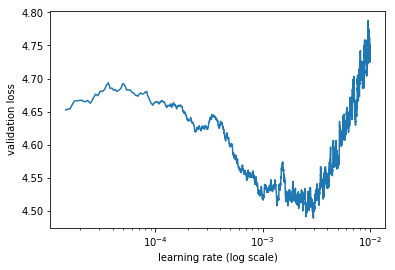

In [37]:
learner.sched.plot()

In [38]:
# start doing epochs for the full model ... 
# lesson 4 after 14 epochs had a 4.23 loss ... here after one epoch have 4.12 epoch loss
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

# bs 52, bptt=70 notebook (March 31, 2019)
#epoch      trn_loss   val_loss   accuracy                       
#    0      4.331119   4.16258    0.285376
#    5      4.053623   3.978126   0.303586 
#    8      3.968421   3.951115   0.30676  
#    11     3.909159   3.93127    0.30937                        
#    12     3.889581   3.926714   0.310039
#    14     3.909791   3.915993   0.311308   

#epoch      trn_loss   val_loss   accuracy 
# 0      4.338338   4.175916   0.284463
# 2      4.174276   4.063725   0.295824   
# 3      4.134645   4.040154   0.298624
# 5      4.074611   4.007141   0.30222  
# 7      4.052532   3.982075   0.304748
# 9      3.990863   3.969266   0.30669 
# 10     4.025941   3.95892    0.307883
# 11     3.962463   3.955428   0.308491 
# 12     3.951181   3.947853   0.309556
# 13     3.92437    3.944853   0.309967   
# 14     3.94222    3.939546   0.310581 




epoch      trn_loss   val_loss   accuracy                       
    0      4.342637   4.163584   0.285316  
  5%|▌         | 350/6869 [04:02<1:14:00,  1.47it/s, loss=4.34]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    1      4.226193   4.085613   0.292141                       
    2      4.139725   4.040766   0.297033                       
 61%|██████▏   | 4215/6869 [47:34<30:16,  1.46it/s, loss=4.14]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    3      4.089726   4.013811   0.299732                       
    4      4.061208   3.993925   0.301871                       
    5      4.031773   3.979702   0.303671                       
  3%|▎         | 186/6869 [02:06<1:16:59,  1.45it/s, loss=4.04]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      4.059679   3.96636    0.304913                       
 66%|██████▋   | 4555/6869 [51:27<27:20,  1.41it/s, loss=4]     

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    7      3.989331   3.958235   0.305902                       
 54%|█████▎    | 3681/6869 [41:33<38:24,  1.38it/s, loss=3.99]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    9      3.964807   3.942696   0.30779                        
 35%|███▍      | 2391/6869 [27:05<52:19,  1.43it/s, loss=3.98]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 65%|██████▍   | 4446/6869 [50:23<26:01,  1.55it/s, loss=3.93]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 97%|█████████▋| 6667/6869 [1:15:22<02:20,  1.44it/s, loss=3.93]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    13     3.883847   3.922323   0.310715                       
 18%|█▊        | 1233/6869 [13:58<1:02:54,  1.49it/s, loss=3.91]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [39]:
learner.save('lm1')

In [40]:
learner.save_encoder('lm1_enc')

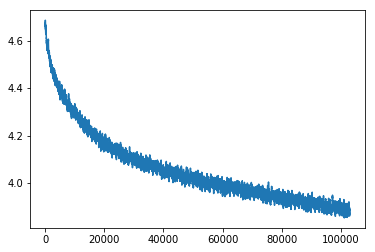

In [41]:
learner.sched.plot_loss()

## save_encoder [1:31:55]

You’ll see there are two different versions of save. 
* save saves the whole model as per usual - LinearDecoder(n_tok, emb_sz, dropout, tie_encoder=enc) (which is the bit that actually makes it into a language model). - * We don’t care about that bit in the classifier, 
* save_encoder just saves that bit - just rnn_enc - this is what the classifier uses

<img src="./pics/save_encoder.png" style="height:200px;width:600px;" >



## 1.7 Measuring LM Accuracy

Measuring accuracy [1:21:45]
One important idea which may seem minor but again it’s incredibly controversial is that we should measure accuracy when we look at a language model . Normally for language models, we look at a loss value which is just cross entropy loss but specifically we nearly always take e to the power of that which the NLP community calls “perplexity”. So perplexity is just e^(cross entropy). There is a lot of problems with comparing things based on cross entropy loss. 

Not sure if there’s time to go into it in detail now, but the basic problem is that it is like that thing we learned about focal loss. Cross entropy loss — if you are right, it wants you to be really confident that you are right. So it really penalizes a model that doesn’t say “I’m so sure this is wrong” and it’s wrong. Whereas accuracy doesn’t care at all about how confident you are — it cares about whether you are right. This is much more often the thing which you care about in real life. The accuracy is how often do we guess the next word correctly and it’s a much more stable number to keep track of. So that’s a simple little thing that Jeremy does.

We train for a while and we get down to a 3.9 cross entropy loss which is equivalent of ~49.40 perplexity (e^3.9) [1:23:14]. To give you a sense of what’s happening with language models, if you look at academic papers from about 18 months ago, you’ll see them talking about state-of-the-art perplexity of over a hundred. The rate at which our ability to understand language and measuring language model accuracy or perplexity is not a terrible proxy for understanding language. If I can guess what you are going to say next, I need to understand language well and the kind of things you might talk about pretty well. The perplexity number has just come down so much that it’s been amazing, and it will come down a lot more. NLP in the last 12–18 months, it really feels like 2011–2012 computer vision. We are starting to understand transfer learning and fine-tuning, and basic models are getting so much better. Everything you thought about what NLP can and can’t do is rapidly going out of date. There’s still lots of things NLP is not good at to be clear. Just like in 2012, there were lots of stuff computer vision wasn’t good at. But it’s changing incredibly rapidly and now is a very very good time to be getting very good at NLP or starting startups base on NLP because there is a whole bunch of stuff which computers would absolutely terrible at two years ago and now not quite good as people and then next year, they’ll be much better than people.

**Question:** What is your ratio of paper reading vs. coding in a week [1:25:24]? Gosh, what do you think, Rachel? You see me. I mean, it’s more coding, right? “It’s a lot more coding. I feel like it also really varies from week to week” (Rachel). With that bounding box stuff, there were all these papers and no map through them, so I didn’t even know which one to read first and then I’d read the citations and didn’t understand any of them. So there was a few weeks of just kind of reading papers before I even know what to start coding. That’s unusual though. Anytime I start reading a paper, I’m always convinced that I’m not smart enough to understand it, always, regardless of the paper. And somehow eventually I do. But I try to spend as much time as I can coding.
Nearly always after I’ve read a paper [1:26:34], even after I’ve read the bit that says this is the problem I’m trying to solve, I’ll stop there and try to implement something that I think might solve that problem. And then I’ll go back and read the paper, and I read little bits about these are how I solve these problem bits, and I’ll be like “oh that’s a good idea” and then I’ll try to implement those. That’s why for example, I didn’t actually implement SSD. My custom head is not the same as their head. It’s because I kind of read the gist of it and then I tried to create something as best as I could, then go back to the papers and try to see why. So by the time I got to the focal loss paper, Rachel will tell you, I was driving myself crazy with how come I can’t find small objects? How come it’s always predicting background? I read the focal loss paper and I was like “that’s why!!” It’s so much better when you deeply understand the problem they are trying to solve. I do find the vast majority of the time, by the time I read that bit of the paper which is solving a problem, I’m then like “yeah, but these three ideas I came up with, they didn’t try.” Then you suddenly realize that you’ve got new ideas. Or else, if you just implement the paper mindlessly, you tend not to have these insights about better ways to do it .

Question: Is your dropout rate the same through the training or do you adjust it and weights accordingly [1:26:27]? Varying dropout is really interesting and there are some recent papers that suggest gradually changing dropout [1:28:09]. It was either good idea to gradually make it smaller or gradually make it bigger, I’m not sure which. Maybe one of us can try and find it during the week. I haven’t seen it widely used. I tried it a little bit with the most recent paper I wrote and I had some good results. I think I was gradually make it smaller, but I can’t remember.

Question: Am I correct in thinking that this language model is build on word embeddings? Would it be valuable to try this with phrase or sentence embeddings? I ask this because I saw from Google the other day, universal sentence encoder [1:28:45]. This is much better than that. This is not just an embedding of a sentence, this is an entire model. An embedding by definition is like a fixed thing. A sentence or a phase embedding is always a model that creates that. We’ve got a model that’s trying to understand language. It’s not just as phrase or as sentence — it’s a document in the end, and it’s not just an embedding that we are training through the whole thing. This has been a huge problem with NLP for years now is this attachment they have to embeddings. Even the paper that the community has been most excited about recently from AI2 (Allen Institute for Artificial Intelligence) called ELMo — they found much better results across lots of models, but again it was an embedding. They took a fixed model and created a fixed set of numbers which they then fed into a model. But in computer vision, we’ve known for years that that approach of having fixed set of features, they’re called hyper columns in computer vision, people stopped using them like 3 or 4 years ago because fine-tuning the entire model works much better. For those of you that have spent quite a lot of time with NLP and not much time with computer vision, you’re going to have to start re-learning. All that stuff you have been told about this idea that there are these things called embeddings and that you learn them ahead of time and then you apply these fixed things whether it be word level or phrase level or whatever level — don’t do that. You want to actually create a pre-trained model and fine-tune it end-to-end, then you’ll see some specific results.

Question: For using accuracy instead of perplexity as a metric for the model, could we work that into the loss function rather than just use it as a metric [1:31:21]? No, you never want to do that whether it be computer vision or NLP or whatever. It’s too bumpy. So cross entropy is fine as a loss function. And I’m not saying instead of, I use it in addition to. I think it’s good to look at the accuracy and to look at the cross entropy. But for your loss function, you need something nice and smoothy. Accuracy doesn’t work very well.